In [1]:
import os, glob, re, sys
import socket
import torch
import wandb
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pandas as pd
import umap
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook

sys.path.append('../')
from src.vae_models import *
from src.datasets import Astro_lightcurves
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

main_path = os.path.dirname(os.getcwd())

save_plots = False
save_tables = False

In [2]:
ID = 'b68z1hwo'
gpu = False

In [3]:
if not os.path.exists('%s/wandb/run--%s/VAE_model_None.pt' % 
                      (main_path, ID)):
    print('Downloading files from Weight & Biases')
    
    api = wandb.Api()
    run = api.run('jorgemarpa/Phy-VAE/%s' % (ID))
    run.file('VAE_model_None.pt').download(replace=True, 
                                           root='%s/wandb/run--%s/' % 
                                           (main_path, ID))
    run.file('config.yaml').download(replace=True, 
                                     root='%s/wandb/run--%s/' % 
                                     (main_path, ID))

device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

## Load model variables into VAE model

In [4]:
vae, config = load_model_list(ID=ID)
config

Loading from... 
 /Users/jorgetil/Astro/PELS-VAE/wandb/run--b68z1hwo/VAE_model_None.pt
Is model in cuda?  False


{'architecture': 'tcn',
 'batch_size': 128,
 'beta_vae': '0.75',
 'classes': 'all',
 'data': 'OGLE3',
 'dropout': 0.2,
 'epochs': 150,
 'feed_pp': 'F',
 'hidden_size': 48,
 'kernel_size': 5,
 'label_dim': 8,
 'latent_dim': 4,
 'latent_mode': 'repeat',
 'learning_rate': 0.001,
 'learning_rate_scheduler': 'cos',
 'n_feats': 3,
 'n_train_params': 300897,
 'num_layers': 9,
 'phys_params': '',
 'physics_dim': 0,
 'sequence_lenght': 600,
 'transpose': False,
 'normed': True,
 'folded': True,
 'date': '',
 'ID': 'b68z1hwo'}

In [5]:
dataset = Astro_lightcurves(survey=config['data'],
                            band='I' if config['data'] else 'B',
                            use_time=True,
                            use_err=True,
                            norm=config['normed'],
                            folded=config['folded'],
                            machine=socket.gethostname(),
                            seq_len=config['sequence_lenght'],
                            phy_params=config['phys_params'])

if config['classes'].split('_')[0] == 'drop':
    dataset.drop_class(config['classes'].split('_')[1])
elif config['classes'].split('_')[0] == 'only':
    dataset.only_class(config['classes'].split('_')[1])
print('Using physical parameters: ', dataset.phy_names)
dataset.remove_nan()
print(dataset.class_value_counts())
print('Total: ', len(dataset))
num_cls = dataset.labels_onehot.shape[1]

dataloader, _ = dataset.get_dataloader(batch_size=100, 
                                       test_split=0., shuffle=False)

Loading from:
 /Users/jorgetil/Google Drive/Colab_Notebooks/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz
Using physical parameters:  []
ELL      10365
RRLYR    10169
CEP      10045
LPV      10044
ECL      10000
DSCT      5090
T2CEP     5047
ACEP      5000
Name: Type, dtype: int64
None
Total:  65760


In [7]:
config

{'architecture': 'tcn',
 'batch_size': 128,
 'beta_vae': '0.75',
 'classes': 'all',
 'data': 'OGLE3',
 'dropout': 0.2,
 'epochs': 150,
 'feed_pp': 'F',
 'hidden_size': 48,
 'kernel_size': 5,
 'label_dim': 8,
 'latent_dim': 4,
 'latent_mode': 'repeat',
 'learning_rate': 0.001,
 'learning_rate_scheduler': 'cos',
 'n_feats': 3,
 'n_train_params': 300897,
 'num_layers': 9,
 'phys_params': '',
 'physics_dim': 0,
 'sequence_lenght': 600,
 'transpose': False,
 'normed': True,
 'folded': True,
 'date': '',
 'ID': 'b68z1hwo'}

In [8]:
mu, std = evaluate_encoder(vae, dataloader, config, 
                           n_classes=num_cls, force=False)

Loading from files...


# Plot LC reconstruction

In [9]:
examples = []
meta_aux = dataset.meta.reset_index()
for i, cls in enumerate(dataset.label_onehot_enc.categories_[0]):
    aux = meta_aux.query('Type == "%s"' % (cls)).sample(3)
    examples.append(aux)
examples = pd.concat(examples, axis=0)
print(examples.index)


data, lb, onehot, pp = dataset[examples.index]
data = torch.from_numpy(data).to(device)
onehot = torch.from_numpy(onehot).to(device)
pp = torch.from_numpy(pp).to(device)

if config['label_dim'] > 0 and config['physics_dim'] > 0:
    xhat_z, mu_, logvar_, z_ = vae(data, label=onehot, phy=pp)
    xhat_mu = vae.decoder(mu_, data[:,:,0], label=onehot, phy=pp)
elif config['label_dim'] > 0 and config['physics_dim'] == 0:
    xhat_z, mu_, logvar_, z_ = vae(data, label=onehot)
    xhat_mu = vae.decoder(mu_, data[:,:,0], label=onehot)
elif config['label_dim'] == 0:
    xhat_z, mu_, logvar_, z_ = vae(data)
    xhat_mu = vae.decoder(mu_, data[:,:,0])
else:
    print('Check conditional dimension...')

xhat_z = torch.cat([data[:,:,0].unsqueeze(-1), xhat_z], dim=-1).detach().numpy()
xhat_mu = torch.cat([data[:,:,0].unsqueeze(-1), xhat_mu], dim=-1).detach().numpy()
data = data.detach().numpy()

Int64Index([ 1501,  2586,  2653, 15008,  8184, 10774, 17933, 19237, 18156,
            20956, 23865, 28878, 38920, 38245, 38270, 48738, 41264, 47279,
            58041, 55511, 54915, 65119, 64425, 61987],
           dtype='int64')


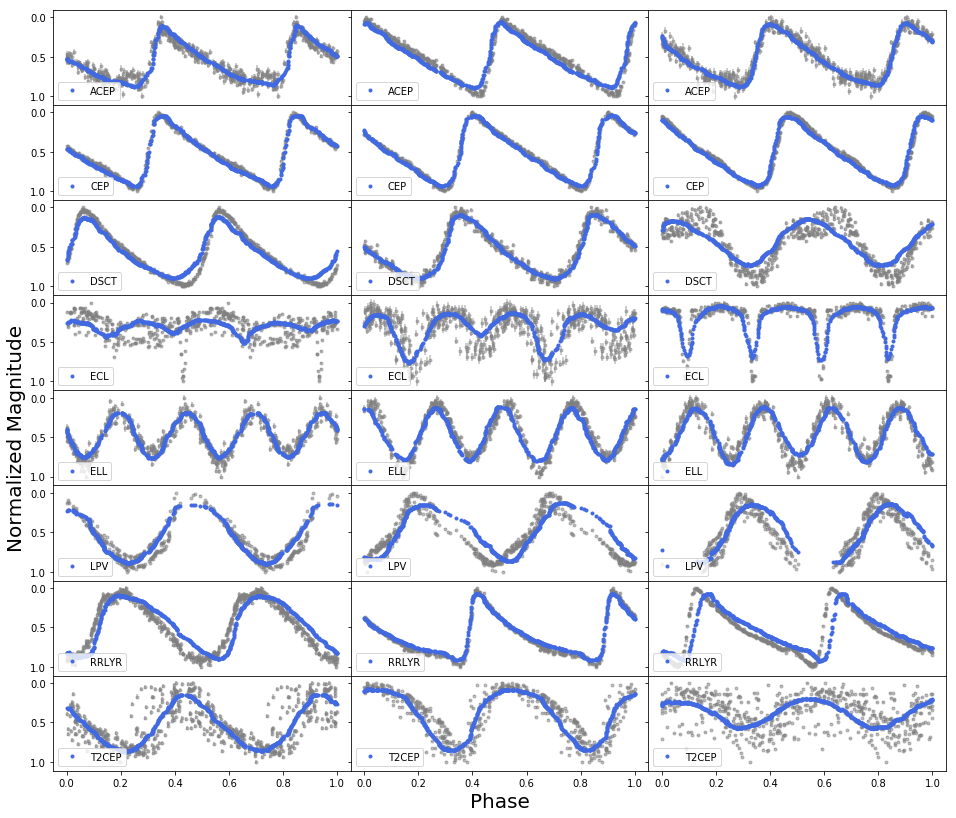

In [10]:
plot_wall_lcs(xhat_mu, data, cls=lb, save=save_plots)

# Joint distributions of latent variables

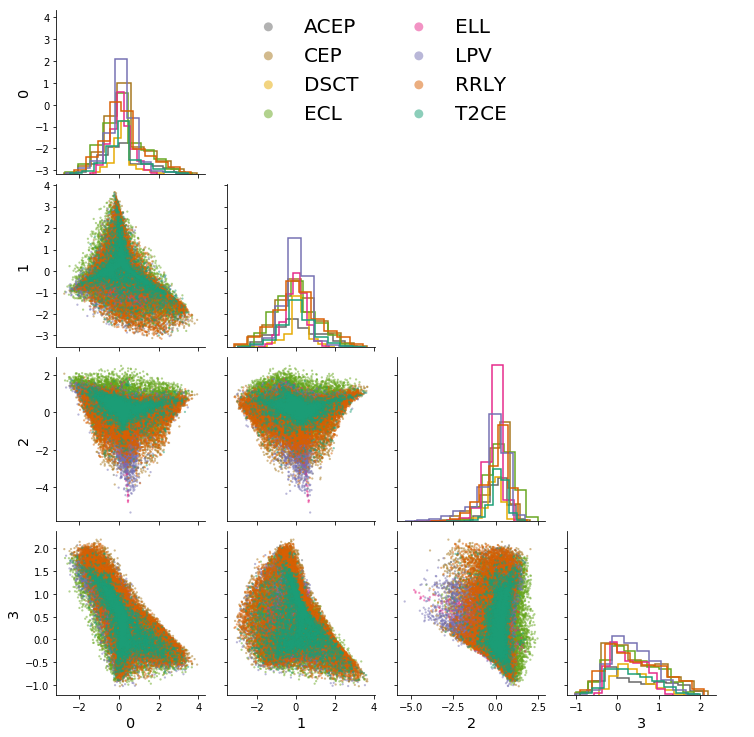

In [11]:
g = sb.PairGrid(mu, 
                hue='class', hue_order=sorted(set(mu.loc[:,'class'].values)),
               corner=False, despine=True, palette='Dark2_r')
g = g.map_diag(plt.hist, histtype='step', lw=1.5)
g = g.map_offdiag(plt.scatter, marker='.', s=20, alpha=.5, edgecolors='none')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g = g.add_legend(loc='upper center', fontsize=20, title='', 
                 markerscale=4, ncol=2)    
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')

if save_plots:
    plt.savefig('%s/imgs/z_pairplot_%s.pdf' % (path,ID), 
            format='pdf', bbox_inches='tight')
    
plt.show()

### tSNE projection to 2D

In [12]:
mu.shape, dataset.meta.shape

((65760, 5), (65760, 23))

In [15]:
rnd_idx = np.random.choice(mu.index.values, replace=False, size=20000)
mu_to_tsne = mu.loc[rnd_idx]
meta_to_tsne = dataset.meta.loc[rnd_idx]
print(meta_to_tsne.Type.value_counts())

#for perplex in [2,5,8,10,15,20,25,30,40,50,100]:
tsne = TSNE(n_components=2, perplexity=40, 
            random_state=10, verbose=0)
mu_embed = tsne.fit_transform(mu_to_tsne.iloc[:,:-1].values)
print('Embeding shape: ', mu_embed.shape)

ELL      3232
CEP      3067
ECL      3057
RRLYR    3050
LPV      3025
ACEP     1540
DSCT     1516
T2CEP    1513
Name: Type, dtype: int64
Embeding shape:  (20000, 2)


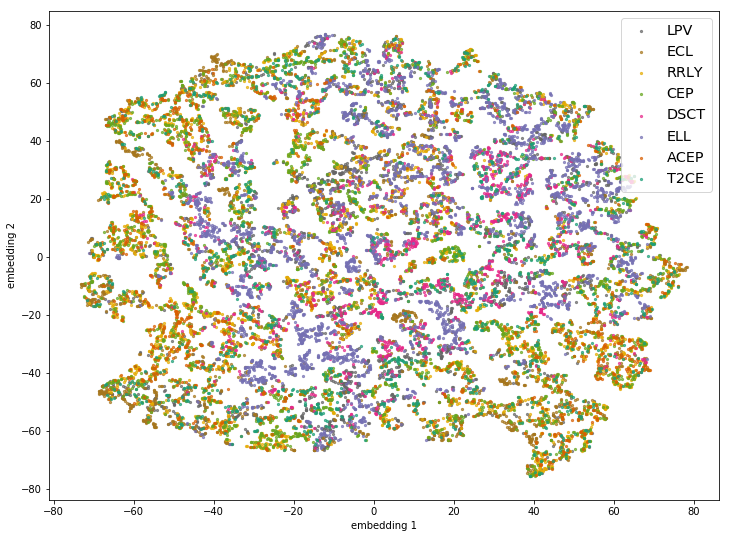

No handles with labels found to put in legend.


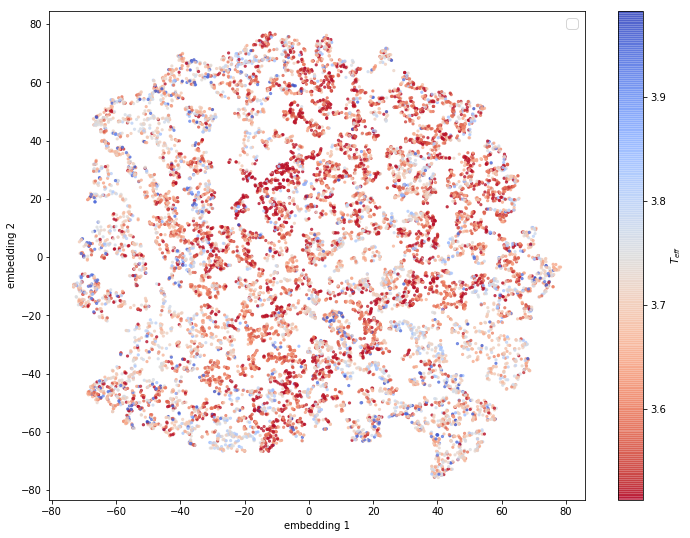

No handles with labels found to put in legend.


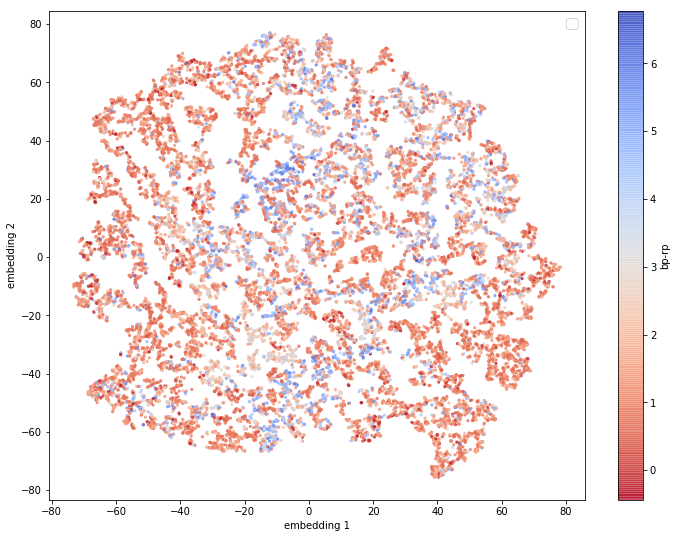

No handles with labels found to put in legend.


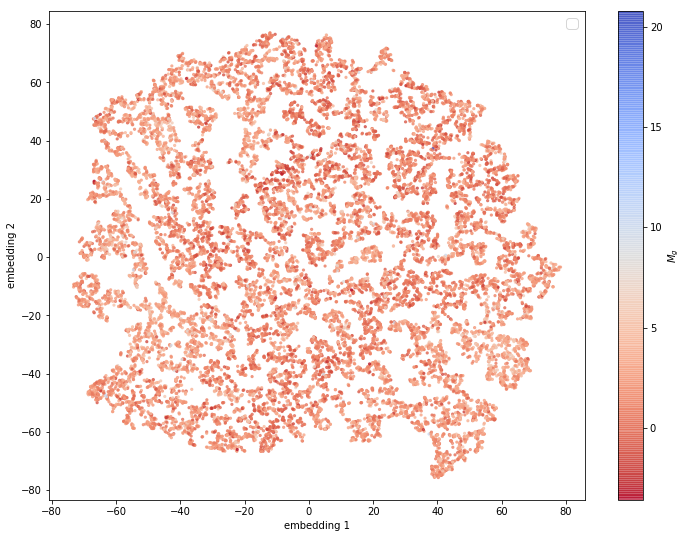

No handles with labels found to put in legend.


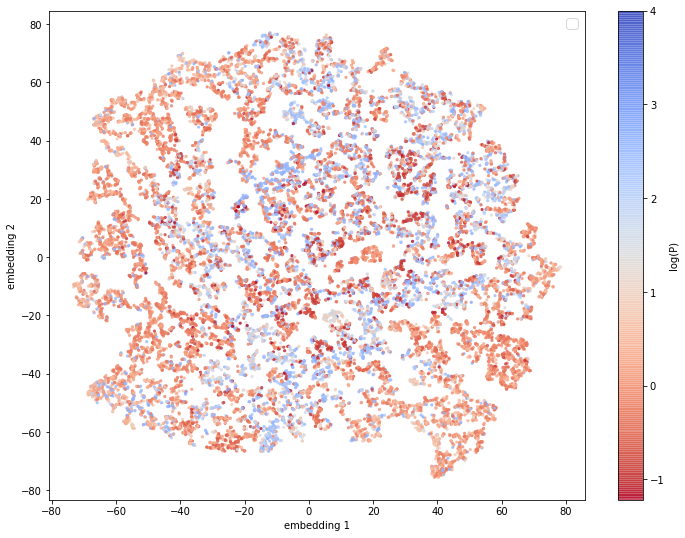

No handles with labels found to put in legend.


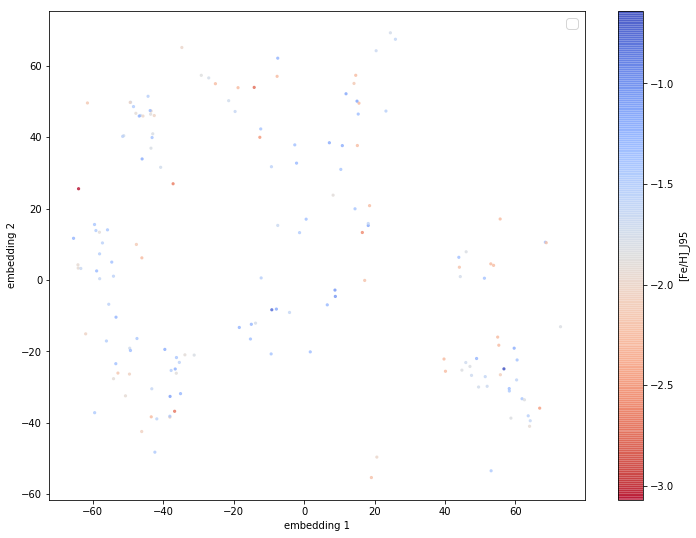

In [17]:
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            mu_to_tsne.loc[:,'class'].values,
            disc=True)
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'teff_val'].values),
            disc=False, c_label=r'$T_{eff}$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

## UMAP projection

In [18]:
umapper = umap.UMAP(n_neighbors=100, min_dist=0.05, 
                    n_components=2, metric='euclidean')
embedding = umapper.fit_transform(mu_to_tsne.iloc[:,:-1].values)

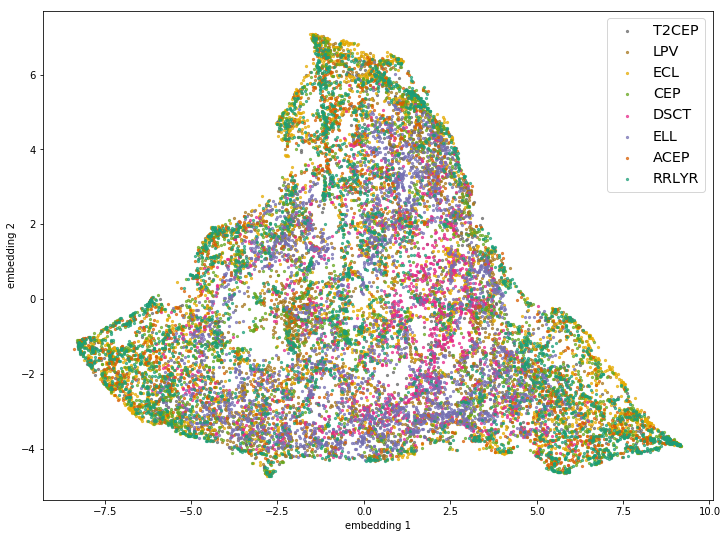

No handles with labels found to put in legend.


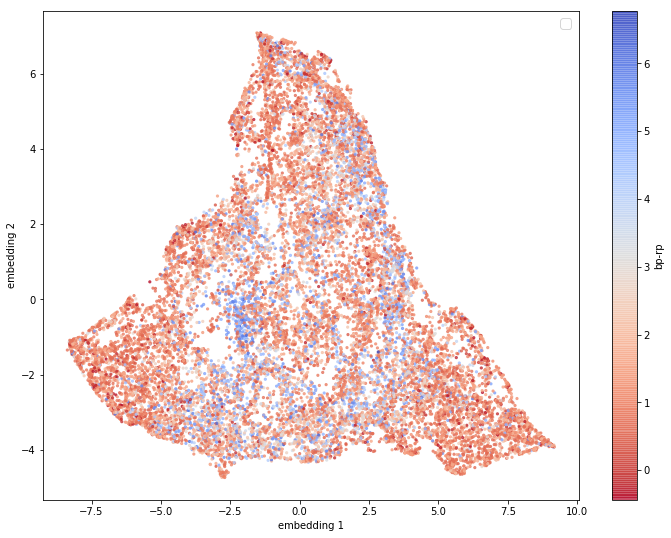

No handles with labels found to put in legend.


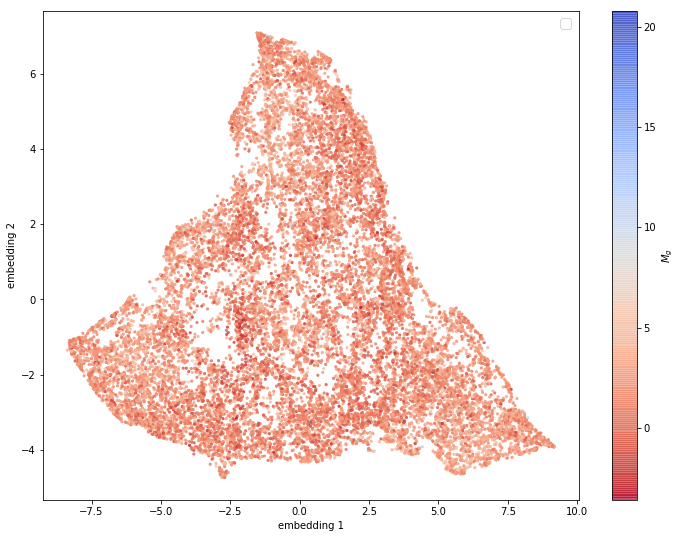

No handles with labels found to put in legend.


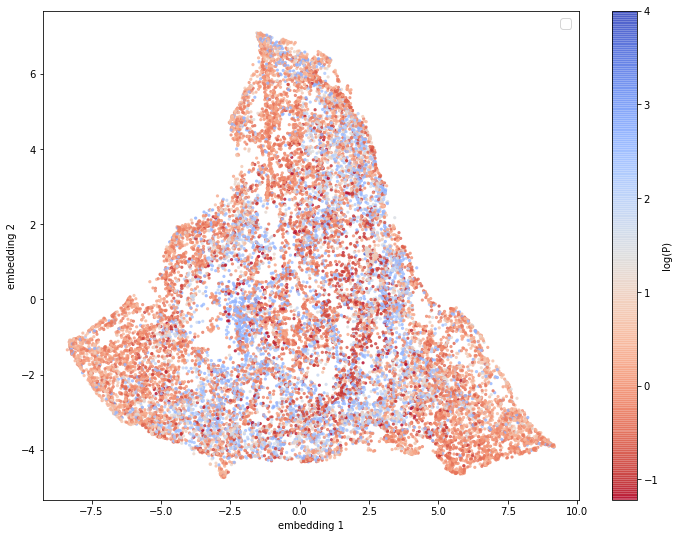

No handles with labels found to put in legend.


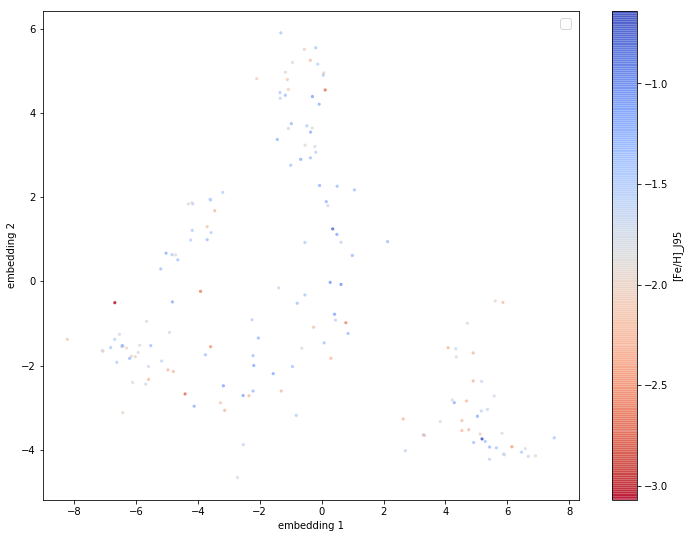

In [20]:
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'Type'].values,
            disc=True)
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(embedding[:,0], embedding[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

# Regressions

In [175]:
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [176]:
phys2 = ['abs_Gmag', 'teff_val', 'Period']

In [177]:
meta_ = dataset.meta.dropna(subset=phys2)
if len(mu) > 30000:
    mu_ = mu.loc[meta_.index].values[:,:-1]
    std_ = std.loc[meta_.index].values[:,:-1]
else:
    mu_ = mu.iloc[:, :-1].values
    std_ = std.iloc[:, :-1].values
mu_ = mu_.astype(np.float64)
std_ = std_.astype(np.float64)
meta_.shape, mu_.shape

((43031, 23), (43031, 4))

In [178]:
unique_idx = meta_.reset_index().drop_duplicates(subset=['OGLE_id']).index
meta_u = meta_.iloc[unique_idx]
mu_u = mu_[unique_idx]
std_u = std_[unique_idx]
meta_u.shape, mu_u.shape, std_u.shape

((21796, 23), (21796, 4), (21796, 4))

In [179]:
meta__ = meta_.copy()
mu__ = mu_.copy()
std__ = std_.copy()

meta_ = meta_u.copy()
mu_ = mu_u.copy()
std_ = std_u.copy()

In [180]:
regressors = {'LinearR': LinearRegression,
              'RFR': RandomForestRegressor,
              'MLPR': MLPRegressor}

config_dict = dict(LinearR=dict(fit_intercept=False),
                   RFR=dict(n_estimators=100,
                            criterion='mse',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features=len(phys2),
                            n_jobs=-1),
                  MLPR=dict(hidden_layer_sizes=(50),
                            activation='tanh',
                            solver='adam',
                            alpha=0.0001,
                            batch_size='auto',
                            learning_rate='constant',
                            learning_rate_init=0.001,
                            power_t=0.5,
                            max_iter=200,
                            shuffle=True,
                            early_stopping=False,
                            validation_fraction=0.1))

In [181]:
meta_.loc[:, phys2].describe()

abs_Gmag      teff_val        Period
count  21796.000000  21796.000000  21796.000000
mean       1.667349   5044.911133     67.701859
std        1.662237   1483.029419    198.483246
min       -3.580621   3252.669922      0.060624
25%        0.593924   4013.709961      0.839533
50%        1.664623   4871.941650      2.811030
75%        2.734200   5559.319946     23.407340
max       10.606666   9644.000000  10000.000000

In [182]:
def plot_ts_seq(lcs, cls):
    n_cols = lcs.shape[0]
    
    plt.close()
    fig, axis = plt.subplots(nrows=1, ncols=n_cols, 
                             figsize=(30,3),
                             sharex=False, sharey=True)
    
    for i, ax in enumerate(axis.flat):
        ax.plot(lcs[i, :, 0],
                lcs[i, :, 1],
                'k.', 
                alpha=.5, label=cls[i])
        if cls[0] != '':
            ax.legend(loc='lower left')
    
        ax.set_xlabel('Phase', fontsize=20)
    axis[0].set_ylabel('Normalized Magnitude', fontsize=20)

    fig.subplots_adjust(hspace=0, wspace=0)
    axis[0].invert_yaxis()
    
    #plt.tight_layout()
    #plt.savefig('%s/imgs/recon_lc_examples_%s.pdf' % 
    #            (path, ID), format='pdf', bbox_inches='tight')
    plt.show()
    return 
    

In [183]:
def gen_batch_lcs_axis(model, N=100, label='RRLYR'):
    ## phys_parms should be in this order: 'abs_Gmag', 'teff_val', 'Period'

    labels = [label]*N
    pp_vec = np.zeros((N,3), dtype=np.float32)
    ## abs G mag
    pp_vec[:,0] = [-0.24]*N #np.linspace(-6, -2, N, dtype=np.float32)
    ## temp
    pp_vec[:,1] = np.linspace(6000, 7500, N, dtype=np.float32)
    ## period
    pp_vec[:,2] = [0.45]*N #np.linspace(30, 1.2, N, dtype=np.float32)
    dt = np.array([np.linspace(0,1,600, dtype=np.float32)]*N)
    
    latent_code = torch.from_numpy(model.predict(pp_vec).astype(np.float32))   
    new_onehot = torch.from_numpy(dataset.label_onehot_enc.transform(np.array(labels).reshape(-1,1)))
    dt_ = torch.from_numpy(dt)
    
    lchat = vae.decoder(latent_code, dt_, label=new_onehot)
    lcs_gen = torch.cat([dt_.unsqueeze(-1), lchat], dim=-1)
    
    return lcs_gen.detach().numpy(), labels, pp_vec

In [184]:
## 'abs_Gmag', 'teff_val', 'Period'
p = meta_.loc[:,phys2].values
z = mu_.copy()

all_lcs = []

for name, reg in regressors.items():
    if name == 'GPR': continue
    print(name)
    
    model = reg(**config_dict[name])
    try:
        model.fit(p, z)
    except MemoryError:
        print('Fail')
        continue
    mse = metrics.mean_squared_error(z, model.predict(p))
    print('mse  : ', mse)
    
    start = datetime.datetime.now()
    
    lcs_gen, labels, pp = gen_batch_lcs_axis(model, N=5, label='RRLYR')
    all_lcs.append(lcs_gen)
    
    end = datetime.datetime.now()
    elapsed = end - start
    print(elapsed.total_seconds(), "s") 
    
    #plot_ts_seq(lcs_gen, labels)
    
    print('______________________________')
    #break

LinearR
mse  :  0.6899358845906489
0.169656 s
______________________________
RFR
mse  :  0.10063455830020895
0.206437 s
______________________________
MLPR
mse  :  0.6867226188257265
0.072416 s
______________________________


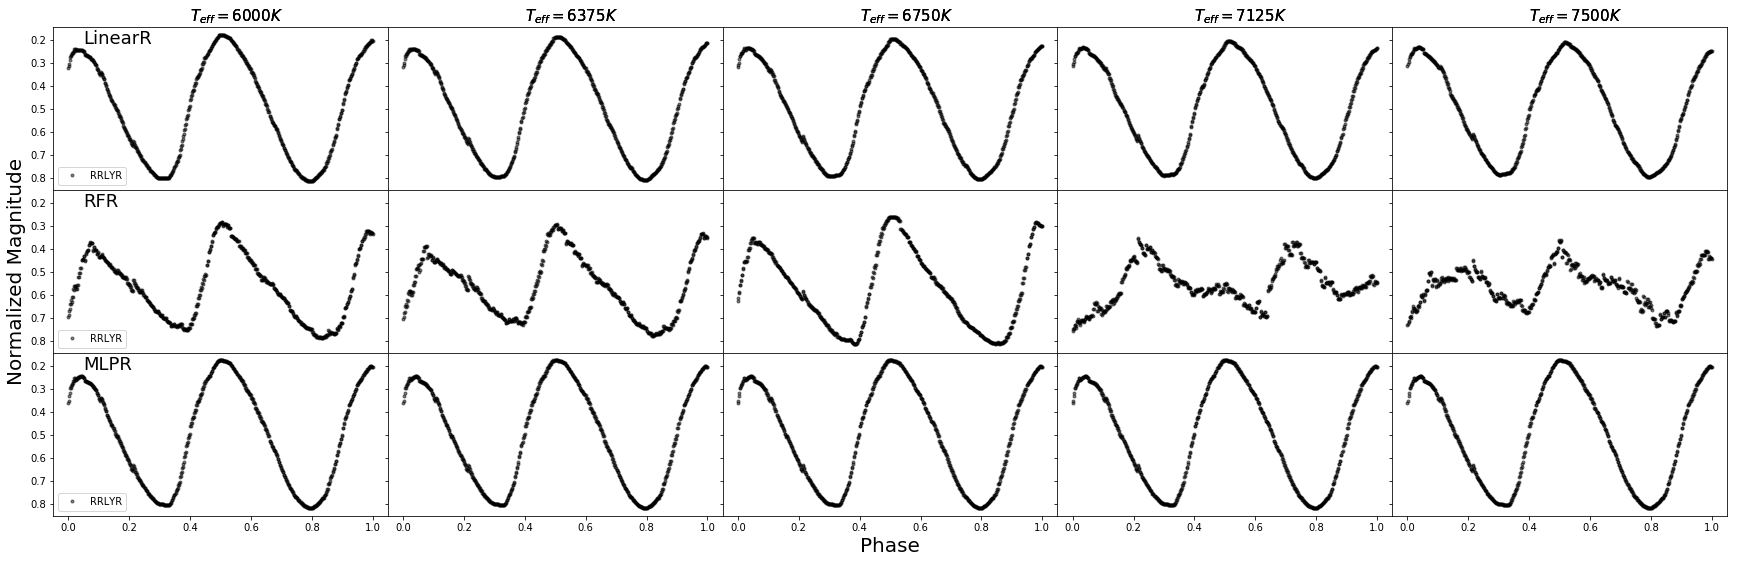

In [185]:
regr_names = list(regressors.keys())

plt.close()
fig, axis = plt.subplots(nrows=len(regressors), ncols=5, 
                         figsize=(30,3*len(regressors)),
                         sharex=True, sharey=True)

for i in range(len(regressors)):
    for j in range(5):
        axis[i, j].plot(all_lcs[i][j, :, 0],
                        all_lcs[i][j, :, 1],
                       'k.', 
                      alpha=.5, label=labels[j])
        axis[0, j].text(0.40,0.12, r'$T_{eff} = %.0f K$' % (pp[j,1]), fontsize=15)
    axis[i, 0].legend(loc='lower left')
    axis[i, 0].text(0.05,0.22, regr_names[i], fontsize=18)
    
    
axis[-1,2].set_xlabel('Phase', fontsize=20)
axis[1,0].set_ylabel('Normalized Magnitude', fontsize=20)

fig.subplots_adjust(hspace=0, wspace=0)
axis[0,0].invert_yaxis()

if save_plots:
    plt.savefig('%s/paper_figures/lc_examples_%s_%s_temp.pdf' % 
               (path, ID, labels[0]), format='pdf', bbox_inches='tight')
plt.show()

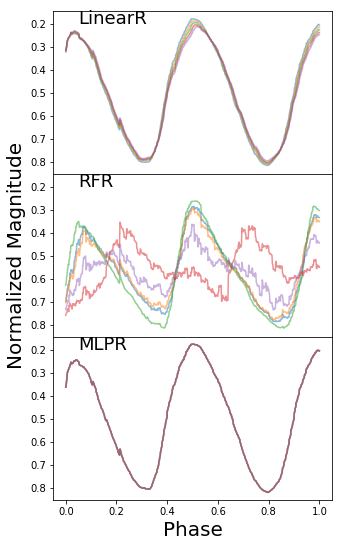

In [186]:
regr_names = list(regressors.keys())

plt.close()
fig, axis = plt.subplots(nrows=len(regressors), ncols=1, 
                         figsize=(5,3*len(regressors)),
                         sharex=True, sharey=True)

for i in range(len(regressors)):
    for j in range(5):
        axis[i,].plot(all_lcs[i][j, :, 0],
                        all_lcs[i][j, :, 1], 
                      alpha=.5, label=labels[j])
    #axis[i,].legend(loc='lower left')
    axis[i,].text(0.05,0.2, regr_names[i], fontsize=18)
    
    
axis[-1].set_xlabel('Phase', fontsize=20)
axis[1].set_ylabel('Normalized Magnitude', fontsize=20)

fig.subplots_adjust(hspace=0, wspace=0)
axis[0].invert_yaxis()

if save_plots:
    plt.savefig('%s/paper_figures/lc_examples_%s_%s_temp.pdf' % 
               (path, ID, labels[0]), format='pdf', bbox_inches='tight')
plt.show()

# Dummy dimension

In [187]:
meta_.shape, mu_.shape, std_.shape

((21796, 23), (21796, 4), (21796, 4))

In [188]:
phys2 = ['abs_Gmag', 'teff_val', 'Period', 'dummy']
z_aug = []
meta_aug = []
aug_factor = 10
with tqdm_notebook(total=len(meta_)) as pbar:
    for i in range(meta_.shape[0]):
        p_aux = pd.concat([meta_.iloc[i]]*aug_factor, axis=1).T
        p_aux.loc[:,'dummy'] = np.random.uniform(size=aug_factor)
        meta_aug.append(p_aux)
        
        z_aux = np.random.normal(loc=mu_[i], scale=std_[i], 
                                 size=[aug_factor, mu_.shape[1]])
        z_aug.append(z_aux)
        pbar.update()
    
z_aug = np.concatenate(z_aug, axis=0)
meta_aug = pd.concat(meta_aug, axis=0)
p_aug = meta_aug.loc[:,phys2].values

In [189]:
p_aug.shape, z_aug.shape

((217960, 4), (217960, 4))

In [190]:
for name, reg in regressors.items():
    if name == 'GPR': continue
    print(name)
    
    model = reg(**config_dict[name])
    model.fit(p_aug, z_aug)
    mse = metrics.mean_squared_error(z_aug, model.predict(p_aug))
    print('mse  : ', mse)
    
    print('______________________________')

LinearR
mse  :  0.6906436761092158
______________________________
RFR
mse  :  0.00035165168687497364
______________________________
MLPR
mse  :  0.6965142873011709
______________________________


In [191]:
np.linspace(0,1,10).reshape(10,1).shape, np.random.uniform(size=(10,1)).shape

((10, 1), (10, 1))

In [192]:
def gen_batch_lcs_same_phy(model, N=100, label='RRLYR', pp=[-.24, 6500, 0.42]):

    labels = [label]*N
    
    pp_vec = np.array([pp for i in range(N)])
    pp_dummy = np.hstack([pp_vec, np.random.uniform(size=(N,1))])
    dt = np.array([np.linspace(0,1,600, dtype=np.float32)]*N)
    
    print(model.predict(pp_dummy))
    
    latent_code = torch.from_numpy(model.predict(pp_dummy).astype(np.float32))   
    new_onehot = torch.from_numpy(dataset.label_onehot_enc.transform(np.array(labels).reshape(-1,1)))
    dt_ = torch.from_numpy(dt)
    
    lchat = vae.decoder(latent_code, dt_, label=new_onehot)
    lcs_gen = torch.cat([dt_.unsqueeze(-1), lchat], dim=-1)
    
    return lcs_gen.detach().numpy(), labels, pp_vec

In [193]:
p_aug.shape, z_aug.shape

((217960, 4), (217960, 4))

LinearR
mse  :  0.6906436761092158
[[ 0.20267082 -0.03298015  0.30723821  0.34821053]
 [ 0.26356928 -0.01624053  0.21364449  0.43150865]
 [ 0.26725166 -0.01522833  0.20798511  0.43654548]
 [ 0.20449219 -0.03247949  0.30443897  0.35070185]
 [ 0.2426525  -0.02199009  0.2457911   0.40289827]]


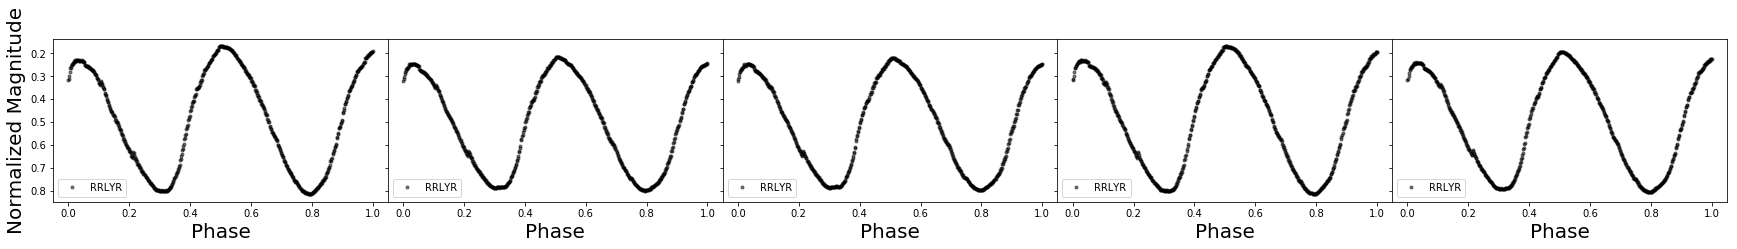

______________________________
RFR
mse  :  0.00035101124252990147
[[ 0.5899044  -0.82965806 -0.24683801  0.39236708]
 [ 0.65052009 -0.79655609 -0.27613855  0.37959815]
 [ 0.64990889 -0.79347364 -0.27806378  0.37730275]
 [ 0.653828   -0.77546563 -0.31115125  0.37465683]
 [ 0.66828189 -0.79068542 -0.2236076   0.39727464]]


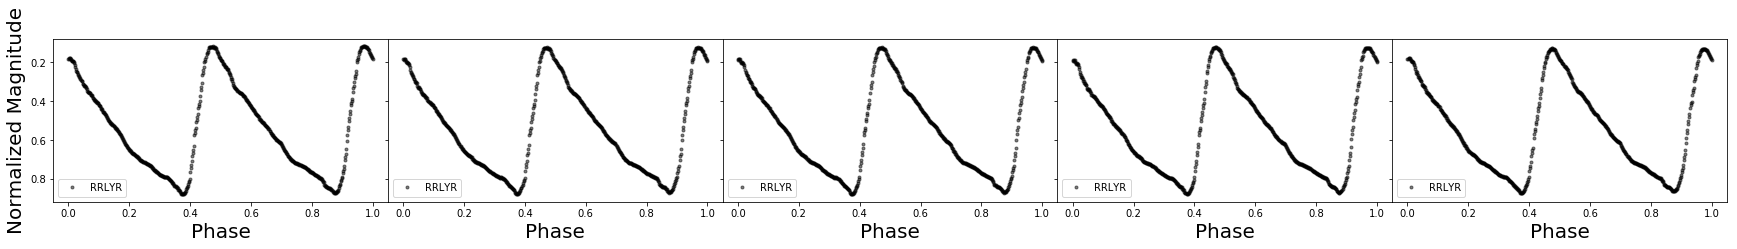

______________________________
MLPR
mse  :  0.6956786115692158
[[0.17631318 0.03165994 0.16510847 0.37650284]
 [0.17631318 0.03165994 0.16510847 0.37650284]
 [0.17631318 0.03165994 0.16510847 0.37650284]
 [0.17631318 0.03165994 0.16510847 0.37650284]
 [0.17631318 0.03165994 0.16510847 0.37650284]]


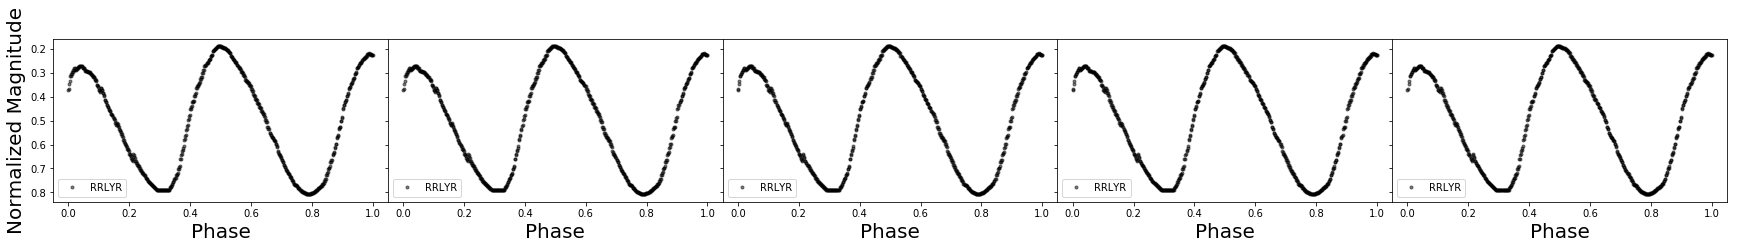

______________________________


In [194]:
## 'abs_Gmag', 'teff_val', 'Period'
all_lcs = []

for name, reg in regressors.items():
    if name == 'GPR': continue
    print(name)
    
    model = reg(**config_dict[name])
    try:
        model.fit(p_aug, z_aug)
    except MemoryError:
        print('Fail')
        continue
    mse = metrics.mean_squared_error(z_aug, model.predict(p_aug))
    print('mse  : ', mse)
    
    lcs_gen, labels, pp = gen_batch_lcs_same_phy(model, N=5, label='RRLYR')
    all_lcs.append(lcs_gen)
    
    plot_ts_seq(lcs_gen, labels)
    
    print('______________________________')
    #break
    

# some code



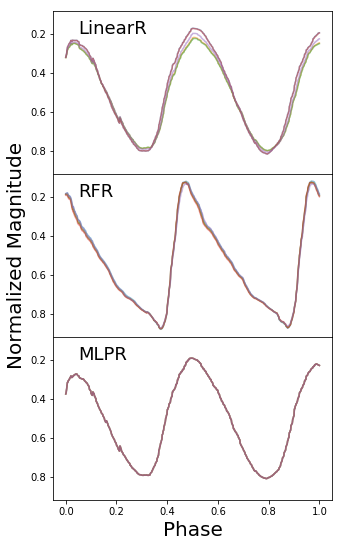

In [195]:
regr_names = list(regressors.keys())

plt.close()
fig, axis = plt.subplots(nrows=len(regressors), ncols=1, 
                         figsize=(5,3*len(regressors)),
                         sharex=True, sharey=True)

for i in range(len(regressors)):
    for j in range(5):
        axis[i,].plot(all_lcs[i][j, :, 0],
                        all_lcs[i][j, :, 1], 
                      alpha=.5, label=labels[j])
    #axis[i,].legend(loc='lower left')
    axis[i,].text(0.05,0.2, regr_names[i], fontsize=18)
    
    
axis[-1].set_xlabel('Phase', fontsize=20)
axis[1].set_ylabel('Normalized Magnitude', fontsize=20)

fig.subplots_adjust(hspace=0, wspace=0)
axis[0].invert_yaxis()

if save_plots:
    plt.savefig('%s/paper_figures/lc_examples_%s_%s_temp.pdf' % 
               (path, ID, labels[0]), format='pdf', bbox_inches='tight')
plt.show()